In [75]:
import pandas as pd
import numpy as np
from scipy import  stats
import matplotlib.pyplot as plt
import datetime
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

In [76]:
import json
import statsmodels.api as sm

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

with open('./arma106107.json') as f:
    data = json.load(f)

df = pd.DataFrame(data).transpose()
df.columns = ['avg', 'top', 'btm', 'tn']
dfa = df.avg

In [77]:
def test_stationarity(timeseries):
    
    #滑動均值和方差
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #給制滑動統計量
    plt.figure(figsize=(24, 8))   
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #adf檢驗
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

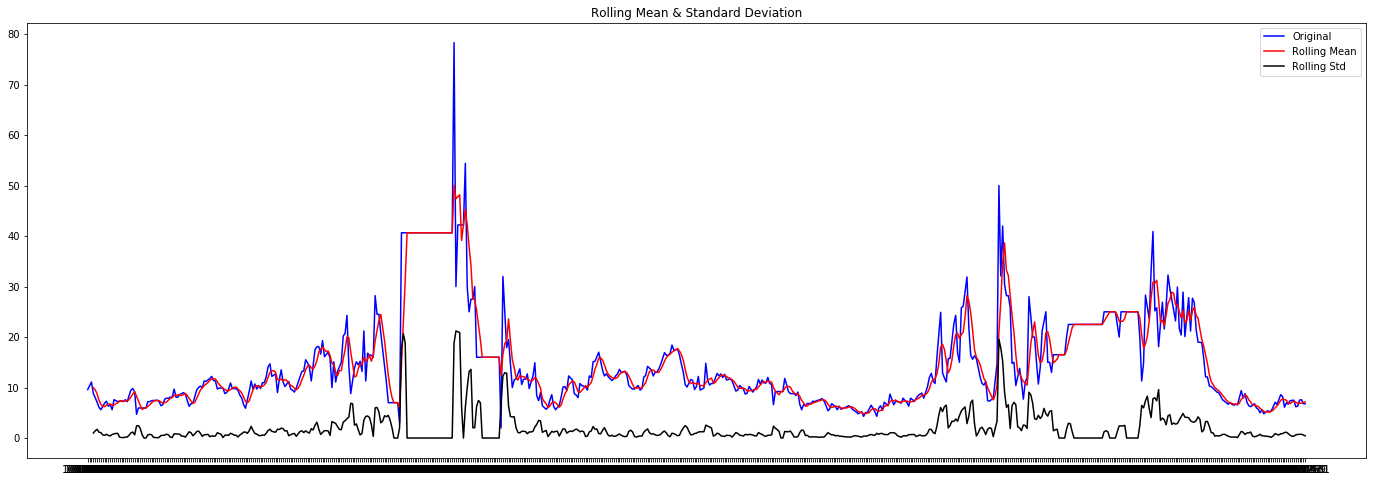

Results of Dickey-Fuller Test:
Test Statistic                  -2.839674
p-value                          0.052826
#Lags Used                      10.000000
Number of Observations Used    638.000000
Critical Value (1%)             -3.440641
Critical Value (5%)             -2.866081
Critical Value (10%)            -2.569188
dtype: float64


In [78]:
test_stationarity(dfa)

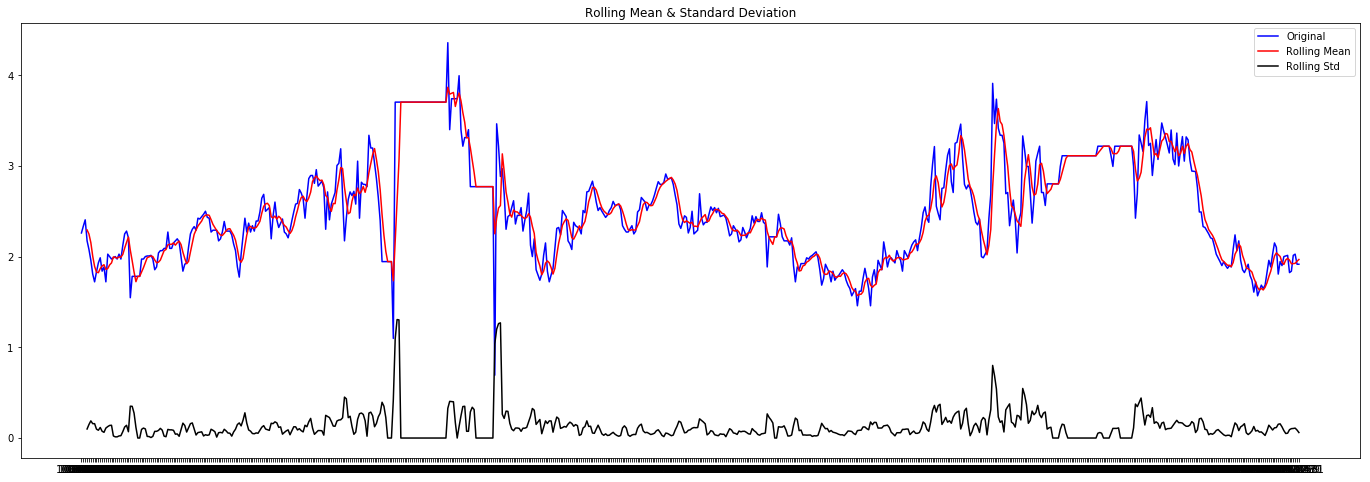

Results of Dickey-Fuller Test:
Test Statistic                  -3.937057
p-value                          0.001778
#Lags Used                       2.000000
Number of Observations Used    646.000000
Critical Value (1%)             -3.440513
Critical Value (5%)             -2.866024
Critical Value (10%)            -2.569158
dtype: float64


In [79]:
#對數 p-value極小 不用再進行差分
dfa_LOG = np.log(dfa)
test_stationarity(dfa_LOG)

In [97]:
dfa_LOG.index

Index(['106.01.01', '106.01.02', '106.01.03', '106.01.04', '106.01.05',
       '106.01.06', '106.01.07', '106.01.08', '106.01.09', '106.01.10',
       ...
       '107.12.22', '107.12.23', '107.12.24', '107.12.25', '107.12.26',
       '107.12.27', '107.12.28', '107.12.29', '107.12.30', '107.12.31'],
      dtype='object', length=649)

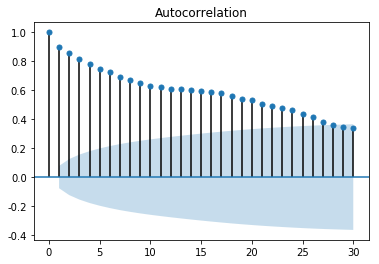

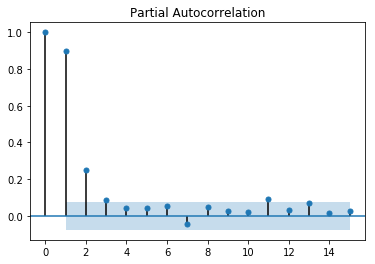

In [81]:
#ACF,PACF
plot_acf(dfa_LOG,lags=30)
plot_pacf(dfa_LOG,lags=15)
plt.show()

In [82]:
#取得p,q參數
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(dfa_LOG,max_ar=3,max_ma=3,ic=['aic', 'bic', 'hqic'])
order.bic_min_order

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', Va

(1, 1)

In [107]:
#擬合
MODEL20=ARMA(dfa_LOG,(1,1)).fit()

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


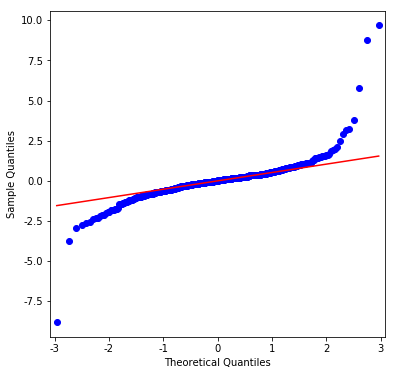

In [108]:
#白噪音檢驗
resid = MODEL20.resid
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [109]:
#檢驗殘差序列相關性
import statsmodels.api as sm
print(sm.stats.durbin_watson(resid.values))

1.9809520870819695


In [121]:
#預測後5筆資訊，原本有0-648筆
PREDICT_ARMA = MODEL20.predict(start=0,end=653)
PREDICT_ARMA.index=PREDICT_ARMA.index+dfa_LOG[0]

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [105]:
dfa_LOG[648]

1.916922612182061

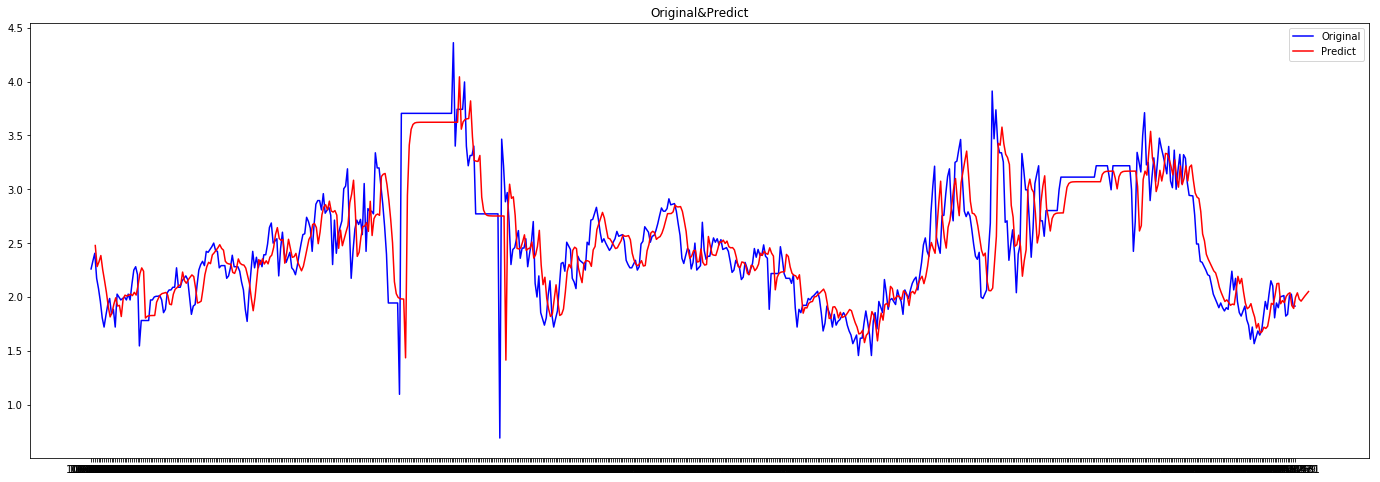

In [122]:
#對比
plt.figure(figsize=(24, 8))   
orig = plt.plot(dfa_LOG, color='blue',label='Original')
predict = plt.plot(PREDICT_ARMA, color='red',label='Predict')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)

In [190]:
#對數還原
PREDICT_dfa = np.exp(PREDICT_ARMA)
PREDICT_dfa.dropna(inplace=True)

In [217]:
PREDICT_dfa.index=PREDICT_dfa.index.astype(np.int64)

In [218]:
PREDICT_dfa.index

Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
            ...
            646, 647, 648, 649, 650, 651, 652, 653, 654, 655],
           dtype='int64', length=654)

In [234]:
print(dfa[0])
print(PREDICT_dfa[650])

9.6
7.251736795333038


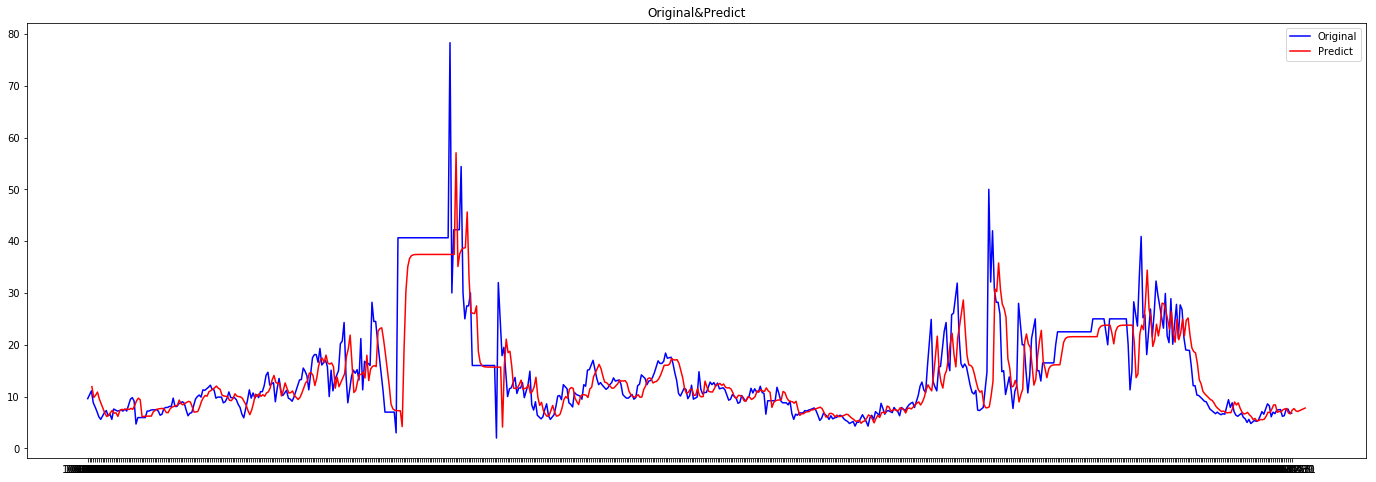

In [166]:
#還原
plt.figure(figsize=(24, 8))   
orig = plt.plot(dfa, color='blue',label='Original')
predict = plt.plot(PREDICT_dfa, color='red',label='Predict')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)